# Import

In [3]:
import pickle
import torch
import tqdm
from PIL import Image
from pathlib import Path
from sklearn.preprocessing import LabelEncoder
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.optim as optim
from matplotlib import pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings(action='ignore', category=DeprecationWarning)
from torchvision import models, transforms as T
import numpy as np
from IPython.display import clear_output, FileLink

In [4]:
!pip install natsort
from natsort import natsorted

In [5]:
import numpy, sklearn, matplotlib, IPython, natsort, PIL, torchvision

libraries = [
    ('torch', torch.__version__),
    ('tqdm', tqdm.__version__),
    ('PIL', PIL.__version__),
    ('sklearn', sklearn.__version__),
    ('matplotlib', matplotlib.__version__),
    ('torchvision', torchvision.__version__),
    ('numpy', numpy.__version__),
    ('IPython', IPython.__version__),
    ('natsort', natsort.__version__),    
]
with open('requriments.txt', 'w') as f:
    for lib in libraries:
        s = f'{lib[0]}=={lib[1]}'
        f.write(s + '\n')
        print(s)

torch==1.11.0
tqdm==4.64.0
PIL==9.1.1
sklearn==1.0.2
matplotlib==3.5.3
torchvision==0.12.0
numpy==1.21.6
IPython==7.33.0
natsort==8.4.0


In [6]:
train_on_gpu = torch.cuda.is_available()
if not train_on_gpu:
    DEVICE = torch.device("cpu")
    print('CUDA is not available.  Training on CPU ...')
else:
    DEVICE = torch.device("cuda")
    print('CUDA is available!  Training on GPU ...')

print(DEVICE)

CUDA is available!  Training on GPU ...
cuda


In [9]:
import sys
print("python version:", sys.version)

python version: 3.7.12 | packaged by conda-forge | (default, Oct 26 2021, 06:08:53) 
[GCC 9.4.0]


# Dataset

In [10]:
class CarColorDataset(Dataset):
    def __init__(self, files, mode):
        super().__init__()
        # list of files to download
        self.files = files
        # operating mode
        self.mode = mode
        self.len_ = len(self.files)    
        self.label_encoder = LabelEncoder()
        if self.mode != 'test':
            self.labels = [path.parent.name for path in self.files]
            self.label_encoder.fit(self.labels)
            with open('label_encoder.pkl', 'wb') as le_dump_file:
                  pickle.dump(self.label_encoder, le_dump_file)                 
    def __len__(self):
        return self.len_

    def load_sample(self, file):
        image = Image.open(file)
        image.load()
        return image

    def _prepare_sample(self, image):
        image = image.resize((224, 224))
        return np.array(image)

    def __getitem__(self, index):
        x = self.load_sample(self.files[index])
        x = self._prepare_sample(x)
        x = np.array(x, dtype='uint8')
        
        if self.mode == 'train':
            x = self.transform_train(x)
        if self.mode == 'val':
            x = self.transform_test(x)
        if self.mode == 'test':
            x = self.transform_test(x)
        
        if self.mode == 'test':
            return x
        else:
            label = self.labels[index]
            label_id = self.label_encoder.transform([label])
            y = label_id.item()
            return x, y
        
    def transform_train(self, image):
        transform = T.Compose([
            T.ToPILImage(),
            T.RandomEqualize(),
            T.ToTensor(),
            T.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
            ])
        return transform(image)
        
    def transform_val(self, image):
        transform = T.Compose([
            T.ToTensor(),
            T.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
        ])
        return transform(image)

    def transform_test(self, image):
        transform = T.Compose([
            T.ToTensor(),
            T.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ])
        return transform(image)

In [11]:
def imshow(inp, title=None, plt_ax=plt):
    """Imshow для тензоров"""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt_ax.imshow(inp)
    if title is not None:
        plt_ax.set_title(title)
    plt_ax.grid(False)

In [14]:
# specify the path to the train and test
TRAIN_DIR = Path('/kaggle/input/car-dataset/car_color_dataset/train')
TEST_DIR = Path('/kaggle/input/car-dataset/car_color_dataset/public_test')
train_val_files = sorted(list(TRAIN_DIR.rglob('*.jpg')))
test_img = natsorted(list(map(str, TEST_DIR.rglob('*.jpg')))) # sort by number
test_files = list(map(Path, test_img))

In [15]:
test_files[:5] # check sorting

[PosixPath('/kaggle/input/car-dataset/car_color_dataset/public_test/0.jpg'),
 PosixPath('/kaggle/input/car-dataset/car_color_dataset/public_test/1.jpg'),
 PosixPath('/kaggle/input/car-dataset/car_color_dataset/public_test/2.jpg'),
 PosixPath('/kaggle/input/car-dataset/car_color_dataset/public_test/3.jpg'),
 PosixPath('/kaggle/input/car-dataset/car_color_dataset/public_test/4.jpg')]

In [16]:
from sklearn.model_selection import train_test_split
train_val_labels = [path.parent.name for path in train_val_files]
train_files, val_files = train_test_split(train_val_files, test_size=0.25, \
                                          stratify=train_val_labels)

In [17]:
val_dataset = CarColorDataset(val_files, mode='val')
train_dataset = CarColorDataset(train_files, mode='train')
test_dataset = CarColorDataset(test_files, mode="test")

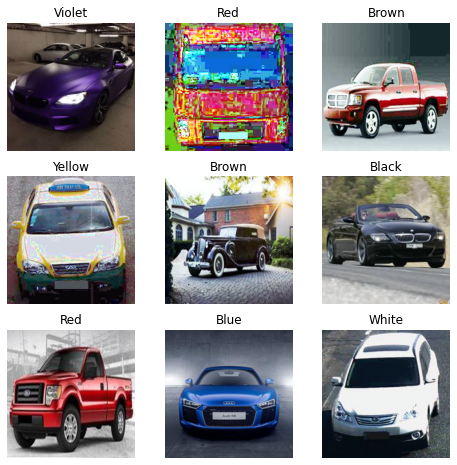

In [22]:
# let's look at images in train
fig, ax = plt.subplots(nrows=3, ncols=3,figsize=(8, 8), \
                        sharey=True, sharex=True)
for fig_x in ax.flatten():
    random_characters = int(np.random.uniform(0,500))
    im_train, label = train_dataset[random_characters]
    img_label = " ".join(map(lambda x: x.capitalize(),\
                train_dataset.label_encoder.inverse_transform([label])[0].split('_')))
    imshow(im_train.data.cpu(), \
          title=img_label,plt_ax=fig_x)
    fig_x.axis(False)

# Model

In [23]:
model = models.resnet101(pretrained=True)

Downloading: "https://download.pytorch.org/models/resnet101-63fe2227.pth" to /root/.cache/torch/hub/checkpoints/resnet101-63fe2227.pth


  0%|          | 0.00/171M [00:00<?, ?B/s]

In [24]:
# resnet
# number of classes to predict
n_classes = len(np.unique(train_val_labels))

# freeze all model weights
for param in model.parameters():
    param.requires_grad = False

# defrost the last 2 layers of the model
# (number of layers/parameters for defrosting obtained experimentally)
for par in model.layer3.parameters():
    par.requires_grad=True
for p in model.layer4.parameters():
    p.requires_grad=True

model.avgpool=nn.AdaptiveAvgPool2d(output_size=(1,1))
model.fc = nn.Linear(in_features=2048, out_features=n_classes, bias=True)

model = model.to(DEVICE)

In [25]:
model # look at the model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 


# Train + validation

In [26]:
BATCH_SIZE = 64

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

In [27]:
from sklearn.metrics import f1_score
def score(y_true, y_pred):
    return f1_score(y_true.cpu().numpy(), y_pred.cpu().numpy(), average='macro')

In [37]:
def train_epoch(model, train_loader, criterion, optimizer, scheduler=None):

    model.train()

    running_loss = 0.0
    running_score = 0
    processed_data = 0

    for inputs, labels in tqdm.tqdm(train_loader):

        inputs = inputs.to(DEVICE)
        labels = labels.to(DEVICE)

        optimizer.zero_grad()
        outputs = model(inputs)
        preds = torch.argmax(outputs, 1)
        loss = criterion(outputs, labels)

        loss.backward()
        optimizer.step()
        
        if scheduler:
            scheduler.step()

        running_loss += loss.item() * inputs.size(0)
        running_score += score(labels.data, preds)
        processed_data += inputs.size(0)

    train_loss = running_loss / processed_data
    train_score = running_score / len(train_loader)

    return train_loss, train_score

In [38]:
def eval_epoch(model, val_loader, criterion):

    model.eval()

    running_loss = 0.0
    running_score = 0
    processed_size = 0

    for inputs, labels in tqdm.tqdm(val_loader):
        
        inputs = inputs.to(DEVICE)
        labels = labels.to(DEVICE)

        with torch.no_grad():
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            preds = torch.argmax(outputs, 1)
            
        running_loss += loss.item() * inputs.size(0)
        running_score += score(labels.data, preds)
        processed_size += inputs.size(0)
        
    val_loss = running_loss / processed_size
    val_score = running_score / len(val_loader)

    return val_loss, val_score

In [39]:
criterion = nn.CrossEntropyLoss()

# lr, step_size and gamma can have other values, they are selected and changed during the training
optimizer = optim.Adam(model.parameters(), lr=2e-4)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=4, gamma=0.2)

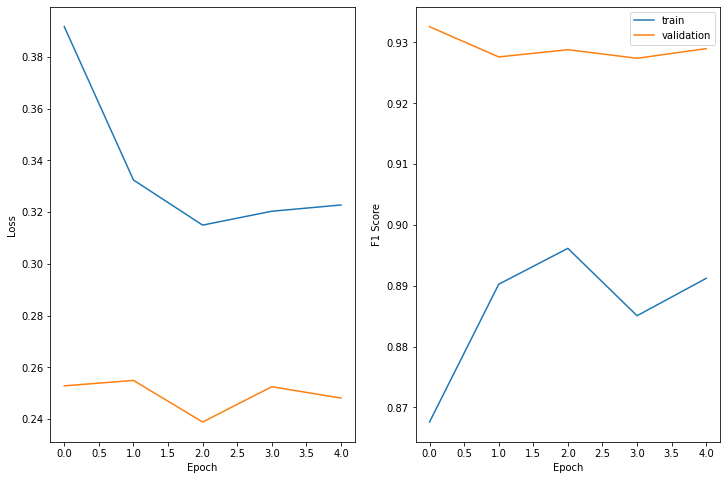

val_score: 0.9289753416759575
val_loss: 0.24809545911574338



In [40]:
# fix models with high score or low loss
min_val_loss = np.inf
max_val_score = -1

# for plotting graphs
history = []

EPOCHS = 5

for epoch in range(EPOCHS):
    print("epoch", epoch + 1)

    train_loss, train_score = train_epoch(model, train_loader, criterion, optimizer, scheduler)
    val_loss, val_score = eval_epoch(model, val_loader, criterion)
    
    history.append((train_loss, train_score, val_loss, val_score))

    train_loss_hist, train_score_hist, val_loss_hist, val_score_hist = zip(*history)
    
    clear_output(True)

    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 8))
    
    ax[0].plot(train_loss_hist, label='train loss')
    ax[0].plot(val_loss_hist, label='validation loss')
    ax[0].set_ylabel('Loss')
    ax[0].set_xlabel('Epoch')
    plt.legend()

    ax[1].plot(train_score_hist, label='train')
    ax[1].plot(val_score_hist, label='validation')
    ax[1].set_ylabel('F1 Score')
    ax[1].set_xlabel('Epoch')

    plt.legend()
    plt.show()
    
    # for exact values
    print("val_score:", val_score)
    print("val_loss:", val_loss, end='\n\n')
    
    # best model in eval loss
    if val_loss_hist[-1] < min_val_loss:
        min_val_loss = val_loss_hist[-1]
        torch.save(model.state_dict(), 'best_val_model.pt')
        
    # best model in eval score
    if val_score_hist[-1] > max_val_score:
        max_val_score = val_score_hist[-1]
        torch.save(model.state_dict(), 'best_score_model.pt')

In [41]:
# need to specify the path to the best model
model.load_state_dict(torch.load('/kaggle/input/final-model/09856_resnet101.pt'))

<All keys matched successfully>

In [42]:
# select the best model based on the validation results from several saved ones
# different models and different approaches to teaching were used
val_loss, val_score = eval_epoch(model, val_loader, criterion)
print("val_score:", val_score)
print("val_loss:", val_loss)

100%|██████████| 15/15 [00:06<00:00,  2.41it/s]

val_score: 0.9735492977713799
val_loss: 0.04600383327210363


In [43]:
# save best model weigts;
torch.save(model.state_dict(), 'best_model.pt')

# Public test

In [44]:
def predict(model, test_loader):
    with torch.no_grad():
        logits = []
        for inputs in tqdm.tqdm(test_loader):
            inputs = inputs.to(DEVICE)
            model.eval()
            outputs = model(inputs).cpu()
            logits.append(outputs)           
    probs = nn.functional.softmax(torch.cat(logits), dim=-1).numpy()
    return probs

In [45]:
result = predict(model, test_loader)
label_encoder = pickle.load(open("label_encoder.pkl", 'rb'))
preds = label_encoder.inverse_transform(np.argmax(result, axis=1))

with open("submit_res101.csv", 'w') as f_res:
    for row in preds:
        f_res.write(row + '\n')
        
display(FileLink("submit_res101.csv"))

100%|██████████| 23/23 [00:12<00:00,  1.90it/s]


/kaggle/working/submit_res101.csv

# Private test

In [49]:
TEST_DIR = Path('/kaggle/input/car-dataset/car_color_dataset/private_test')
train_val_files = sorted(list(TRAIN_DIR.rglob('*.jpg')))
test_img = natsorted(list(map(str, TEST_DIR.rglob('*.jpg')))) # sort by number
test_files = list(map(Path, test_img))

print(len(test_files))
test_files[:5] # check sorting

1434


[PosixPath('/kaggle/input/car-dataset/car_color_dataset/private_test/0.jpg'),
 PosixPath('/kaggle/input/car-dataset/car_color_dataset/private_test/1.jpg'),
 PosixPath('/kaggle/input/car-dataset/car_color_dataset/private_test/2.jpg'),
 PosixPath('/kaggle/input/car-dataset/car_color_dataset/private_test/3.jpg'),
 PosixPath('/kaggle/input/car-dataset/car_color_dataset/private_test/4.jpg')]

In [51]:
test_dataset = CarColorDataset(test_files, mode="test")

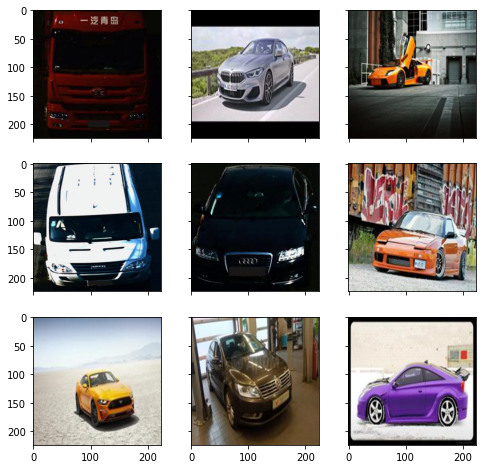

In [52]:
# let's look at private images
fig, ax = plt.subplots(nrows=3, ncols=3,figsize=(8, 8), \
                        sharey=True, sharex=True)
for fig_x in ax.flatten():
    random_characters = int(np.random.uniform(0,500))
    im_test = test_dataset[random_characters]
    
    imshow(im_test.data.cpu(), plt_ax=fig_x)

In [53]:
BATCH_SIZE = 64
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

In [54]:
# need to specify the path to the best model
model.load_state_dict(torch.load('/kaggle/input/final-model/09856_resnet101.pt'))

<All keys matched successfully>

In [56]:
result = predict(model, test_loader)
label_encoder = pickle.load(open("label_encoder.pkl", 'rb'))
preds = label_encoder.inverse_transform(np.argmax(result, axis=1))

assert len(preds) == len(test_files)

with open("submit_final.csv", 'w') as f_res:
    for row in preds:
        f_res.write(row + '\n')
        
display(FileLink("submit_final.csv"))

100%|██████████| 23/23 [00:09<00:00,  2.46it/s]


/kaggle/working/submit_final.csv